In [1]:
import warnings                           
warnings.filterwarnings('ignore')

import datetime
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import lag_plot

from itertools import product
from tqdm import tqdm_notebook

%matplotlib inline

from utils import mean_absolute_percentage_error, timeseries_train_test_split, train_test_split, time_lags_generation, train_and_val_model, optimal_leg_search_1d 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LassoCV, RidgeCV

from sklearn.metrics import r2_score, median_absolute_error, mean_absolute_error
from sklearn.metrics import median_absolute_error, mean_squared_error, mean_squared_log_error

In [2]:
data = pd.read_excel('./data/день - количество блюд.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
print(data.shape)
data.head()

(897, 2)


,date,meals
0,2018-04-06 00:00:00,32.0
1,2018-04-07 00:00:00,8.0
2,2018-04-08 00:00:00,4.0
3,2018-04-09 00:00:00,14.0
4,2018-04-10 00:00:00,5.0


In [3]:
# remove the last row
data = data.iloc[:-1]

In [4]:
data['date'] = pd.to_datetime(data['date'])
post_covid_df = data[data['date'] > '2020-05-01 00:00:00']
post_covid_df.head()

,date,meals
754,2020-05-02,86.0
755,2020-05-03,92.0
756,2020-05-04,89.0
757,2020-05-05,65.0
758,2020-05-06,101.0


In [5]:
post_covid_df.tail(10)

,date,meals
886,2020-09-11,122.0
887,2020-09-12,106.0
888,2020-09-13,113.0
889,2020-09-14,125.0
890,2020-09-15,130.0
891,2020-09-16,144.0
892,2020-09-17,136.0
893,2020-09-18,123.0
894,2020-09-19,110.0
895,2020-09-20,120.0


In [6]:
post_covid_df_time = post_covid_df.set_index('date')

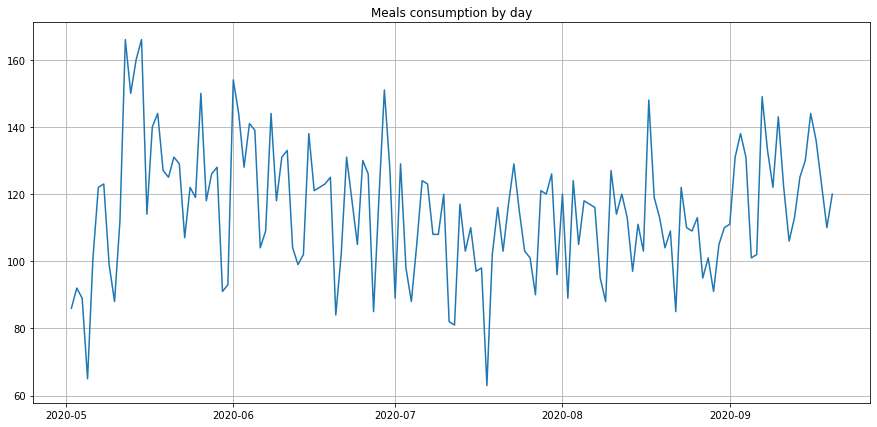

In [7]:
plt.figure(figsize=(15,7))
plt.plot(post_covid_df_time)
plt.title('Meals consumption by day')
plt.grid(True)
plt.show()

In [8]:
# extract the last datepoint of the currect dataframe
latest_entry = post_covid_df.iloc[-1]
latest_datetime = latest_entry['date']

In [9]:
# define the number of days interval to forecast
days_forecast = 7
forecast_date = latest_datetime + datetime.timedelta(days=days_forecast)

# generate a new df for forecast
date_rng = pd.date_range(start=latest_datetime + datetime.timedelta(days=1), end=forecast_date, freq='D')
forecast_df = pd.DataFrame(date_rng, columns=['date'])
forecast_df.head(8)

,date
0,2020-09-21
1,2020-09-22
2,2020-09-23
3,2020-09-24
4,2020-09-25
5,2020-09-26
6,2020-09-27


In [10]:
#concatenate these two df
frames = [post_covid_df, forecast_df]
result_df = pd.concat(frames)
result_df.tail(20)

,date,meals
883,2020-09-08,133.0
884,2020-09-09,122.0
885,2020-09-10,143.0
886,2020-09-11,122.0
887,2020-09-12,106.0
888,2020-09-13,113.0
889,2020-09-14,125.0
890,2020-09-15,130.0
891,2020-09-16,144.0
892,2020-09-17,136.0


In [11]:
result_df = result_df.set_index('date')
result_df.head(10)

,meals
date,
2020-05-02,86.0
2020-05-03,92.0
2020-05-04,89.0
2020-05-05,65.0
2020-05-06,101.0
2020-05-07,122.0
2020-05-08,123.0
2020-05-09,99.0
2020-05-10,88.0


In [12]:
print(result_df.shape)

(149, 1)


In [13]:
result_df = pd.DataFrame(result_df.meals.copy())
result_df.columns = ["target"]

In [14]:
# Adding the lag of the target varable from 7 steps back (week) up to 30 (month)
lag_start = 7
lag_end = 22
result_df = time_lags_generation(result_df, start=lag_start, end=lag_end)
result_df.head(25)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-05-02,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-03,92.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-04,89.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-05,65.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-06,101.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-07,122.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-08,123.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-09,99.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2020-05-10,88.0,92.0,86.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [15]:
result_df.shape

(149, 16)

In [16]:
result_df = result_df[lag_end-1:]
print(result_df.shape)
result_df.head(20)

(128, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-05-23,107.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0,86.0
2020-05-24,122.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0
2020-05-25,119.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0
2020-05-26,150.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0
2020-05-27,118.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0
2020-05-28,126.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0
2020-05-29,128.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0
2020-05-30,91.0,107.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0
2020-05-31,93.0,122.0,107.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0


In [17]:
result_df.tail(25)

,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-09-03,138.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0,97.0,113.0
2020-09-04,131.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0,97.0
2020-09-05,101.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0,111.0
2020-09-06,102.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0,103.0
2020-09-07,149.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0,148.0
2020-09-08,133.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0,119.0
2020-09-09,122.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0,113.0
2020-09-10,143.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0,104.0
2020-09-11,122.0,131.0,138.0,131.0,111.0,110.0,105.0,91.0,101.0,95.0,113.0,109.0,110.0,122.0,85.0,109.0


In [18]:
# use 'n_train' samples for training and the rest for testing

train_df = result_df[:-days_forecast]
print(train_df.shape)
train_df.head(10)

(121, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-05-23,107.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0,86.0
2020-05-24,122.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0
2020-05-25,119.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0
2020-05-26,150.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0
2020-05-27,118.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0
2020-05-28,126.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0
2020-05-29,128.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0
2020-05-30,91.0,107.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0
2020-05-31,93.0,122.0,107.0,129.0,131.0,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0


In [19]:
predict_df = result_df[-days_forecast:]
print(predict_df.shape)
predict_df.head(10)

(7, 16)


,target,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,,
2020-09-21,NaN,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0
2020-09-22,NaN,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0
2020-09-23,NaN,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0
2020-09-24,NaN,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0
2020-09-25,NaN,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0
2020-09-26,NaN,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0
2020-09-27,NaN,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0


In [20]:
target = train_df.target
train_df = train_df.drop(['target'], axis=1)
train_df.head()

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,
2020-05-23,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0,86.0
2020-05-24,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0,92.0
2020-05-25,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0,89.0
2020-05-26,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0,65.0
2020-05-27,125.0,127.0,144.0,140.0,114.0,166.0,160.0,150.0,166.0,112.0,88.0,99.0,123.0,122.0,101.0


In [21]:
predict_df = predict_df.drop(['target'], axis=1)
predict_df.head(10)

,lag_7,lag_8,lag_9,lag_10,lag_11,lag_12,lag_13,lag_14,lag_15,lag_16,lag_17,lag_18,lag_19,lag_20,lag_21
date,,,,,,,,,,,,,,,
2020-09-21,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0,110.0
2020-09-22,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0,111.0
2020-09-23,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0,131.0
2020-09-24,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0,138.0
2020-09-25,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0,131.0
2020-09-26,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0,101.0
2020-09-27,120.0,110.0,123.0,136.0,144.0,130.0,125.0,113.0,106.0,122.0,143.0,122.0,133.0,149.0,102.0


In [22]:
lasso = LassoCV()
lasso.fit(train_df, target)
prediction = lasso.predict(predict_df)
print(prediction)

[121.89641896 123.34671275 124.96418694 127.01031066 120.45359147
 106.63754658 113.95719552]


In [23]:
prediction = [round(x) for x in prediction]
print(prediction)

[122, 123, 125, 127, 120, 107, 114]


Print prediction

In [24]:
prediction_df = pd.DataFrame(prediction, columns= ['meals'])
result_df = pd.concat([forecast_df, prediction_df], axis=1)
result_df.head(10)

,date,meals
0,2020-09-21,122
1,2020-09-22,123
2,2020-09-23,125
3,2020-09-24,127
4,2020-09-25,120
5,2020-09-26,107
6,2020-09-27,114


In [25]:
print(post_covid_df.shape, result_df.shape)

(142, 2) (7, 2)


In [26]:
combined_df = pd.concat([post_covid_df, result_df])
combined_df.tail(15)

,date,meals
888,2020-09-13,113.0
889,2020-09-14,125.0
890,2020-09-15,130.0
891,2020-09-16,144.0
892,2020-09-17,136.0
893,2020-09-18,123.0
894,2020-09-19,110.0
895,2020-09-20,120.0
0,2020-09-21,122.0
1,2020-09-22,123.0


In [27]:
combined_df = combined_df.set_index('date')

In [28]:
combined_df = combined_df.rename(columns = {'meals' : 'pred'})

In [29]:
post_covid_df_time

,meals
date,
2020-05-02,86.0
2020-05-03,92.0
2020-05-04,89.0
2020-05-05,65.0
2020-05-06,101.0
...,...
2020-09-16,144.0
2020-09-17,136.0
2020-09-18,123.0


In [30]:
prediction_df_2d = pd.DataFrame(prediction, columns= ['meals_prediction'])

combined_2d = pd.concat([combined_df, post_covid_df_time], axis=1)
combined_2d.reset_index()

,date,pred,meals
0,2020-05-02,86.0,86.0
1,2020-05-03,92.0,92.0
2,2020-05-04,89.0,89.0
3,2020-05-05,65.0,65.0
4,2020-05-06,101.0,101.0
...,...,...,...
144,2020-09-23,125.0,NaN
145,2020-09-24,127.0,NaN
146,2020-09-25,120.0,NaN
147,2020-09-26,107.0,NaN


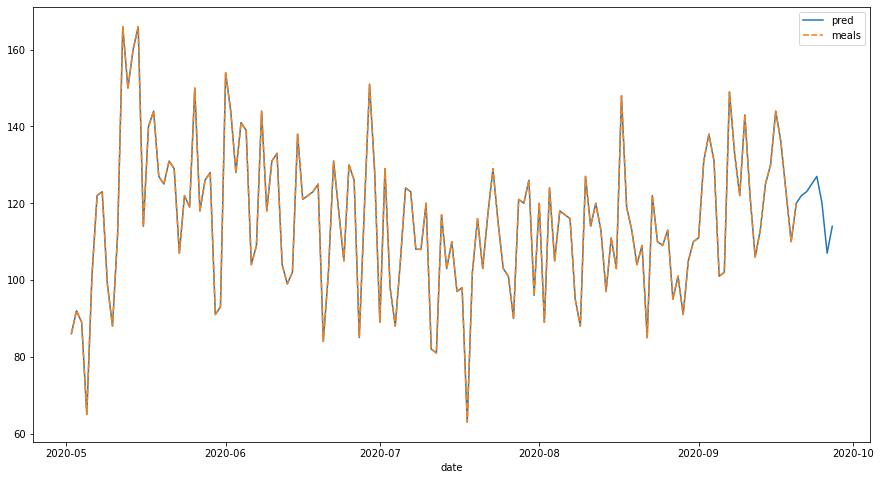

In [31]:
plt.figure(figsize=(15,8))
sns.lineplot(data=combined_2d)

Comparison with an actual data

In [47]:
test_data = pd.read_excel('./data/факт сентябрь.xlsx', skiprows= 3, usecols= [0,1], names = ['date', 'meals'])
# remove the last row
test_data = test_data.iloc[:-1]
print(test_data.shape)
test_data.tail(12)

(30, 2)


,date,meals
18,2020-09-19,110
19,2020-09-20,120
20,2020-09-21,132
21,2020-09-22,134
22,2020-09-23,133
23,2020-09-24,114
24,2020-09-25,124
25,2020-09-26,91
26,2020-09-27,111
27,2020-09-28,166


In [49]:
test_data = test_data[(test_data['date'] > '2020-09-20') & (test_data['date'] < '2020-09-28')]
test_data.head(10)

,date,meals
20,2020-09-21,132
21,2020-09-22,134
22,2020-09-23,133
23,2020-09-24,114
24,2020-09-25,124
25,2020-09-26,91
26,2020-09-27,111


In [51]:
error_df = result_df.merge(test_data, on='date', suffixes=('_pred', '_fact'))
error_df.head(10)

,date,meals_pred,meals_fact
0,2020-09-21,122,132
1,2020-09-22,123,134
2,2020-09-23,125,133
3,2020-09-24,127,114
4,2020-09-25,120,124
5,2020-09-26,107,91
6,2020-09-27,114,111


In [53]:
error = mean_absolute_percentage_error(error_df['meals_fact'], error_df['meals_pred'])
error

8.102026557469449